In [1]:
import numpy as np
import pandas as pd
import scipy.io
import rrcf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

%matplotlib inline

# Test for classification using two clusters

In [2]:
# Set parameters
np.random.seed(0)
n = 256
d = 3
num_trees = 10

# Generate data
X_0 = np.zeros((n, d))
X_1 = np.zeros((n, d))
X_0[:,0] = -5
X_1[:,0] = 5
X_0 += 0.01*np.random.randn(*X_0.shape)
X_1 += 0.01*np.random.randn(*X_1.shape)

# Create two random cut forests
forest_0 = []
forest_1 = []
for _ in range(num_trees):
    tree_0 = rrcf.RCTree(X_0)
    tree_1 = rrcf.RCTree(X_1)
    forest_0.append(tree_0)
    forest_1.append(tree_1)
    
# Generate new points from two different classes
num_points = 500
offsets = np.random.choice([-5, 5], size=num_points)
labels = pd.Series({-5 : 0, 5: 1})[offsets].values
x = 0.01*np.random.randn(num_points, d)
x[:,0] += offsets

# Compute anomaly score for each new point
avg_codisp = np.zeros((num_points, 2))
for index in range(num_points):
    for tree_0, tree_1 in zip(forest_0, forest_1):
        tree_0.insert_point(x[index], index=n + index)
        tree_1.insert_point(x[index], index=n + index)
        avg_codisp[index, 0] += tree_0.codisp(n + index)
        avg_codisp[index, 1] += tree_1.codisp(n + index)
        tree_0.forget_point(n + index)
        tree_1.forget_point(n + index)

avg_codisp /= num_trees

### Test error

In [3]:
predictions = np.argmin(avg_codisp, axis=1)
test_error = 1 - ((predictions == labels).sum()/num_points)
print("Test error: {:.1f}%".format(100*test_error))

Test error: 0.0%


### Classification

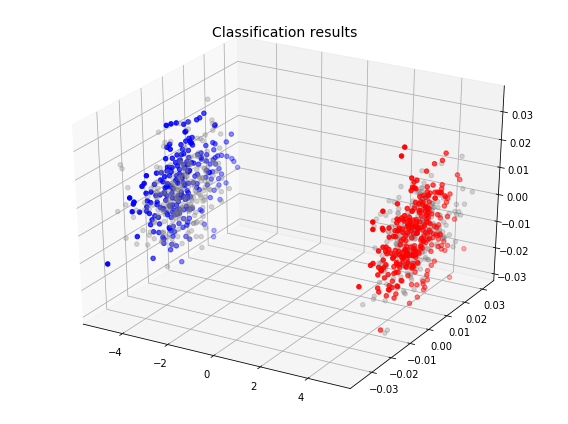

In [4]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_0[:,0], X_0[:,1], X_0[:,2], c='0.5', alpha=0.3)
ax.scatter(X_1[:,0], X_1[:,1], X_1[:,2], c='0.5', alpha=0.3)
ax.scatter(x[predictions == 0][:,0], x[predictions == 0][:,1],
           x[predictions == 0][:,2], c='b')
ax.scatter(x[predictions == 1][:,0], x[predictions == 1][:,1],
           x[predictions == 1][:,2], c='r')
plt.title('Classification results', size=14)
plt.tight_layout()

# Test for classification using nuclear particle data

In [5]:
import seaborn as sns

In [6]:
# Load data
nuc = scipy.io.loadmat('nuclear.mat')
x = nuc['x'].astype(float).T
y = nuc['y'].astype(float).T
y = pd.Series({-1:0, 1:1})[y.ravel()].values

# Set parameters
np.random.seed(0)
n = 1000
m = 100
d = 2
num_trees = 50

# Take random sample
X_0 = x[np.random.choice(np.flatnonzero(y.ravel() == 0), size=n)]
X_1 = x[np.random.choice(np.flatnonzero(y.ravel() == 1), size=n)]

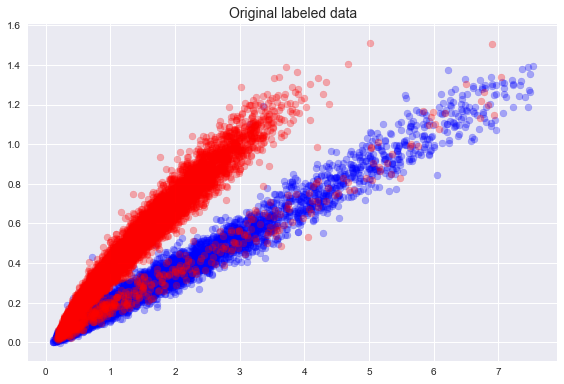

In [7]:
plt.scatter(x[y == 0][:,0], x[y == 0][:,1], c='b', alpha=0.3)
plt.scatter(x[y == 1][:,0], x[y == 1][:,1], c='r', alpha=0.3)
plt.title('Original labeled data', size=14)
plt.tight_layout()

In [8]:
# Create random cut forests
forest_0 = []
forest_1 = []
for _ in range(num_trees):
    tree_0 = rrcf.RCTree(X_0)
    tree_1 = rrcf.RCTree(X_1)
    forest_0.append(tree_0)
    forest_1.append(tree_1)
    
ix = np.random.randint(0, x.shape[0], size=m)
avg_codisp = np.zeros((m, d))

for index in range(m):
    for tree_0, tree_1 in zip(forest_0, forest_1):
        tree_0.insert_point(x[ix[index]], index=n + index)
        tree_1.insert_point(x[ix[index]], index=n + index)
        avg_codisp[index,0] += tree_0.codisp(n + index)
        avg_codisp[index,1] += tree_1.codisp(n + index)
        tree_0.forget_point(n + index)
        tree_1.forget_point(n + index)

avg_codisp /= num_trees

In [9]:
predictions = np.argmin(avg_codisp, axis=1)
test_error = 1 - (predictions == y[ix]).sum() / m
print("Test error: {:.1f}%".format(100*test_error))

Test error: 9.0%


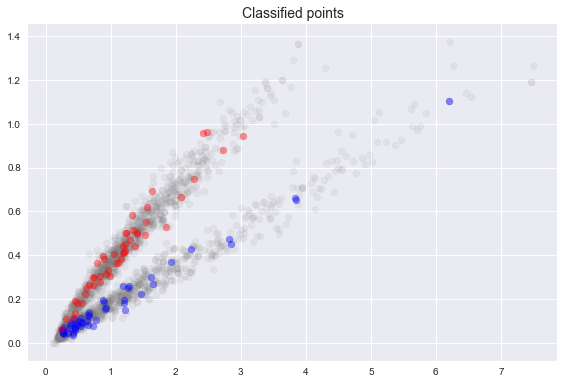

In [10]:
plt.scatter(X_0[:,0], X_0[:,1], c='0.5', alpha=0.1)
plt.scatter(X_1[:,0], X_1[:,1], c='0.5', alpha=0.1)
plt.scatter(x[ix][predictions == 0][:,0], x[ix][predictions == 0][:,1], c='b', alpha=0.4)
plt.scatter(x[ix][predictions == 1][:,0], x[ix][predictions == 1][:,1], c='r', alpha=0.4)
plt.title('Classified points', size=14)
plt.tight_layout()

In [11]:
nn = 2500
num_trees = 10

# Create random cut forests
forest_0 = []
forest_1 = []
for _ in range(num_trees):
    tree_0 = rrcf.RCTree(X_0)
    tree_1 = rrcf.RCTree(X_1)
    forest_0.append(tree_0)
    forest_1.append(tree_1)
    
points = np.vstack(np.dstack(np.meshgrid(np.linspace(0, 8, 50),
                                         np.linspace(0, 1.4, 50))))
avg_codisp = np.zeros((nn, d))

for index in range(nn):
    for tree_0, tree_1 in zip(forest_0, forest_1):
        tree_0.insert_point(points[index], index=n + index)
        tree_1.insert_point(points[index], index=n + index)
        avg_codisp[index,0] += tree_0.codisp(n + index)
        avg_codisp[index,1] += tree_1.codisp(n + index)
        tree_0.forget_point(n + index)
        tree_1.forget_point(n + index)

avg_codisp /= num_trees

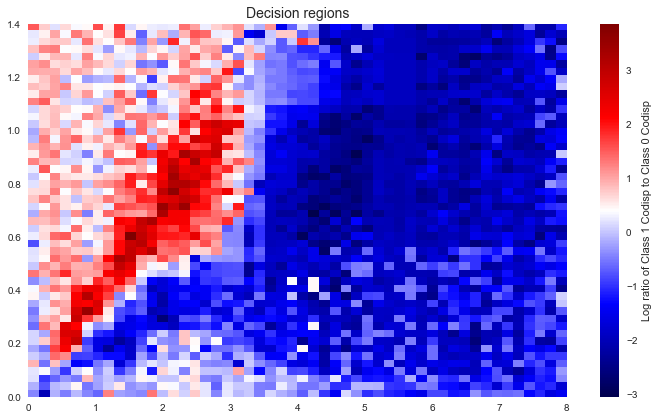

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(-np.log(avg_codisp[:,1] / avg_codisp[:,0]).reshape(50, 50), cmap='seismic', extent=(0, 8, 0, 1.4), origin='lower',
           aspect='auto')
plt.colorbar(label='Log ratio of Class 1 Codisp to Class 0 Codisp')
plt.grid('off')
plt.title('Decision regions', size=14)
plt.tight_layout()

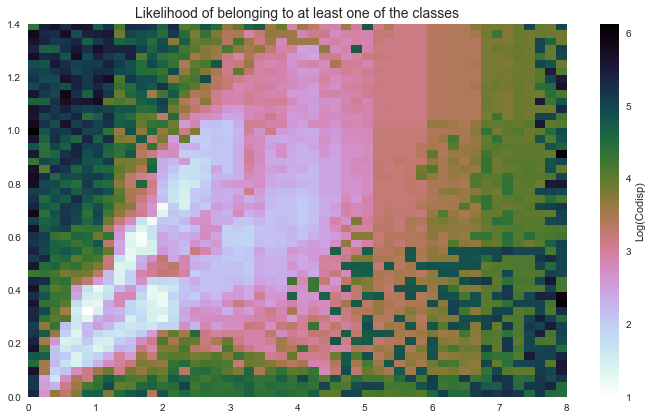

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
plt.imshow(np.log(np.min(avg_codisp, axis=1)).reshape(50, 50), extent=(0, 8, 0, 1.4), origin='lower',
           aspect='auto', cmap='cubehelix_r')
plt.colorbar(label='Log(Codisp)')
plt.grid('off')
plt.title('Likelihood of belonging to at least one of the classes', size=14)
plt.tight_layout()